### Using a TRILEGAL file for a given healpix, produce maps with Mr - [Fe/H] priors 

Version with a subsample of the hipscat TRILEGAL catalog processed with LSDB

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from dask.distributed import Client
pd.set_option('display.max_columns', None)

In [2]:
import os
import shutil
from collections import defaultdict

def delete_files_and_directories(directory):
    # Dictionary to store the count of each file extension
    extension_counts = defaultdict(int)
    file_count = 0
    dir_count = 0
    
    # Walk through the directory
    for root, dirs, files in os.walk(directory, topdown=False):
        # Delete files and collect their extensions
        for file in files:
            file_path = os.path.join(root, file)
            file_extension = os.path.splitext(file)[1]  # Get file extension
            extension_counts[file_extension] += 1
            os.remove(file_path)
            file_count += 1
        
        # Delete directories
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            shutil.rmtree(dir_path)
            dir_count += 1
    
    # Print the results
    print(f'Total files deleted: {file_count}')
    print(f'Total directories deleted: {dir_count}')
    print('File extensions and their counts:')
    for ext, count in extension_counts.items():
        print(f'{ext}: {count}')
    
    return file_count, dir_count, dict(extension_counts)

In [3]:
client = Client(n_workers=96, threads_per_worker=1, memory_limit="auto", dashboard_address=':41987')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41987/status,
Dashboard: http://127.0.0.1:41987/status,Workers: 192
Total threads: 192,Total memory: 22.35 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42551,Workers: 192
Dashboard: http://127.0.0.1:41987/status,Total threads: 192
Started: Just now,Total memory: 22.35 TiB
Comm: tcp://127.0.0.1:33179,Total threads: 1
Dashboard: http://127.0.0.1:33345/status,Memory: 119.21 GiB
Nanny: tcp://127.0.0.1:43219,


## LSDB

/home/seanmcgu/.pyenv/versions/photod/lib/python3.10/site-packages/hats/inspection/visualize_catalog.py:195: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


CPU times: user 9.32 s, sys: 1.87 s, total: 11.2 s
Wall time: 6.78 s


(<Figure size 1000x500 with 2 Axes>, <WCSAxes: >)

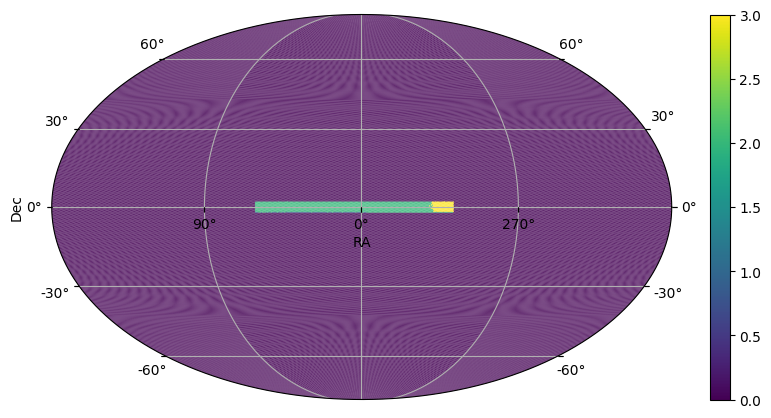

In [5]:
%%time
import lsdb
from lsdb.core.search import BoxSearch

trilegal = lsdb.read_hats("/mnt/beegfs/scratch/data/TRILEGAL/TRILEGAL_hats/TRILEGAL_level_5_cluster/", search_filter=BoxSearch(ra=(-53, 61), dec=(-2., 2.)))

trilegal.skymap(lambda df, a: np.log10(len(df)+1), order=9)

In [10]:
%%time

from photod import priors

def prep(df, pix):
    subdir = f'{rootdir}/{str(pix.order)}'
    rootname = f'{subdir}/{str(pix.pixel)}'
    
    if not os.path.exists(subdir):
        os.makedirs(subdir)
        print(f'Directory created: {subdir}')
    else:
        print(f"Directory already exists: {subdir}")


    priors.dumpPriorMaps_testing(df, rootname, pix, verbose=False)
    return pd.DataFrame(data=[(pix, len(df))], columns=['HealPix', 'len'])

rootdir = '/mnt/beegfs/scratch/seanmcgu/photod/priors/TRILEGAL/S82'  # TODO: clean this up!

# Perform the deletion and gather statistics
delete_files_and_directories(rootdir)
trilegal.map_partitions(prep, include_pixel=True).compute()

Total files deleted: 5797
Total directories deleted: 2
File extensions and their counts:
.npz: 5589
.txt: 208
Directory created: /mnt/beegfs/scratch/seanmcgu/photod/priors/TRILEGAL/S82/0
sample <class 'nested_pandas.nestedframe.core.NestedFrame'>
Healpix:  Order: 0, Pixel: 0 
---------------------------------------
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make ma

,HealPix,len
0,"Order: 5, Pixel: 0",68428
0,"Order: 5, Pixel: 1",16888
0,"Order: 5, Pixel: 2",16430
0,"Order: 5, Pixel: 3072",315340
0,"Order: 5, Pixel: 3073",69024
...,...,...
0,"Order: 5, Pixel: 9214",16127
0,"Order: 5, Pixel: 9215",66475
0,"Order: 5, Pixel: 12285",67952
0,"Order: 5, Pixel: 12286",78620


CPU times: user 29 s, sys: 12.3 s, total: 41.4 s
Wall time: 1min 58s

In [11]:
client.close()

Directory already exists: /mnt/beegfs/scratch/seanmcgu/photod/priors/TRILEGAL/S82/5
sample <class 'nested_pandas.nestedframe.core.NestedFrame'>
Healpix:  Order: 5, Pixel: 4693 
---------------------------------------
Directory already exists: /mnt/beegfs/scratch/seanmcgu/photod/priors/TRILEGAL/S82/5
sample <class 'nested_pandas.nestedframe.core.NestedFrame'>
Healpix:  Order: 5, Pixel: 7509 
---------------------------------------
Directory already exists: /mnt/beegfs/scratch/seanmcgu/photod/priors/TRILEGAL/S82/5
sample <class 'nested_pandas.nestedframe.core.NestedFrame'>
Healpix:  Order: 5, Pixel: 4692 
---------------------------------------
Directory already exists: /mnt/beegfs/scratch/seanmcgu/photod/priors/TRILEGAL/S82/5
sample <class 'nested_pandas.nestedframe.core.NestedFrame'>
Healpix:  Order: 5, Pixel: 7508 
---------------------------------------
Directory already exists: /mnt/beegfs/scratch/seanmcgu/photod/priors/TRILEGAL/S82/5
sample <class 'nested_pandas.nestedframe.core.Ne